In [1]:
import pandas as pd
import sqlite3
import os

In [4]:
# Conecta ao banco de dados (cria se não existir)
conn = sqlite3.connect('bgg.db')

# Encontra todos os arquivos .csv na pasta
arq = [item.split('.')[0] for item in os.listdir('bases') if item.endswith('.csv')]

arq

['artists_reduced',
 'designers_reduced',
 'games',
 'mechanics',
 'publishers_reduced',
 'ratings_distribution',
 'subcategories',
 'themes',
 'user_ratings']

In [ ]:
for arquivo in arq:
    # Lê o arquivo CSV
    df = pd.read_csv(os.path.join('bases', arquivo))
    
    # Remove espaços em branco dos nomes das colunas
    df.columns = df.columns.str.strip()
    
    # Salva o DataFrame no banco de dados, substituindo a tabela se já existir
    tabela_nome = arquivo.split('.')[0]  # Nome da tabela sem a extensão .csv
    df.to_sql(tabela_nome, conn, if_exists='replace', index=False)
    
    print(f'Tabela {tabela_nome} criada com sucesso!')

Tabela artists_reduced criada com sucesso!
Tabela designers_reduced criada com sucesso!
Tabela games criada com sucesso!
Tabela mechanics criada com sucesso!
Tabela publishers_reduced criada com sucesso!
Tabela ratings_distribution criada com sucesso!
Tabela subcategories criada com sucesso!
Tabela themes criada com sucesso!
Tabela user_ratings criada com sucesso!


In [ ]:
# head em latex da tabela user_ratings
print(pd.read_sql('SELECT * FROM user_ratings LIMIT 5', conn).to_latex(index=False, escape=True))

\begin{tabular}{rrl}
\toprule
BGGId & Rating & Username \\
\midrule
213788 & 8.000000 & Tonydorrf \\
213788 & 8.000000 & tachyon14k \\
213788 & 8.000000 & Ungotter \\
213788 & 8.000000 & brainlocki3 \\
213788 & 8.000000 & PPMP \\
\bottomrule
\end{tabular}



In [22]:
# head da tabela games
df = pd.read_sql('SELECT * FROM games LIMIT 5', conn) #.columns.tolist()
print(df.columns)
#df = pd.DataFrame(df, columns=['Variáveis'])

#df['Descrição das variáveis'] = None

#table_latex = df.to_latex(index=False, escape=False)

#print(table_latex)

Index(['BGGId', 'Name', 'Description', 'YearPublished', 'GameWeight',
       'AvgRating', 'BayesAvgRating', 'StdDev', 'MinPlayers', 'MaxPlayers',
       'ComAgeRec', 'LanguageEase', 'BestPlayers', 'GoodPlayers', 'NumOwned',
       'NumWant', 'NumWish', 'NumWeightVotes', 'MfgPlaytime', 'ComMinPlaytime',
       'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings', 'NumComments',
       'NumAlternates', 'NumExpansions', 'NumImplementations',
       'IsReimplementation', 'Family', 'Kickstarted', 'ImagePath',
       'Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts',
       'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames',
       'Rank:partygames', 'Rank:childrensgames', 'Cat:Thematic',
       'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract',
       'Cat:Party', 'Cat:Childrens'],
      dtype='object')


In [26]:
# head da tabela games
df = pd.read_sql('SELECT * FROM mechanics LIMIT 5', conn).columns.tolist()
print(df)
#df = pd.DataFrame(df, columns=['Variáveis'])

#df['Descrição das variáveis'] = None

#table_latex = df.to_latex(index=False, escape=False)

#print(table_latex)

['BGGId', 'Alliances', 'Area Majority / Influence', 'Auction/Bidding', 'Dice Rolling', 'Hand Management', 'Simultaneous Action Selection', 'Trick-taking', 'Hexagon Grid', 'Once-Per-Game Abilities', 'Set Collection', 'Tile Placement', 'Action Points', 'Investment', 'Market', 'Square Grid', 'Stock Holding', 'Victory Points as a Resource', 'Enclosure', 'Pattern Building', 'Pattern Recognition', 'Modular Board', 'Network and Route Building', 'Point to Point Movement', 'Melding and Splaying', 'Negotiation', 'Trading', 'Push Your Luck', 'Income', 'Race', 'Random Production', 'Variable Set-up', 'Roll / Spin and Move', 'Variable Player Powers', 'Action Queue', 'Bias', 'Grid Movement', 'Lose a Turn', 'Programmed Movement', 'Scenario / Mission / Campaign Game', 'Voting', 'Events', 'Paper-and-Pencil', 'Player Elimination', 'Role Playing', 'Movement Points', 'Simulation', 'Variable Phase Order', 'Area Movement', 'Commodity Speculation', 'Cooperative Game', 'Deduction', 'Sudden Death Ending', 'Conn

In [33]:
# Fecha a conexão com o banco de dados
conn.close()

| Tipo de filtragem                         | Variáveis principais                                                                                                                                                                                                                                                                 | Objetivo                                                                                       |
| ----------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------------- |
| **Conteúdo (categorias/mecânicas)**       | - `Cat:Thematic`, `Cat:Strategy`, `Cat:War`, `Cat:Family`, `Cat:CGS`, `Cat:Abstract`, `Cat:Party`, `Cat:Childrens` <br> - Mecânicas (se disponível, ex.: `Dice Rolling`, `Hand Management`, etc.) <br> - `MinPlayers`, `MaxPlayers`, `ComMinPlaytime`, `ComMaxPlaytime`, `MfgAgeRec` | Capturar **similaridade de estilo/tema/mecânica** entre jogos para recomendação personalizada  |
| **Colaborativa (popularidade/qualidade)** | - `NumUserRatings` (confiabilidade da nota) <br> - `BayesAvgRating` (média ponderada) <br> - `AvgRating` (opcional) <br> - `NumOwned` (popularidade) <br> - `Rank:boardgame`, `Rank:*` (posição no ranking geral ou por categoria)                                                   | Filtrar jogos **populares e bem avaliados**, evitar recomendar jogos obscuros ou mal avaliados |


Perfeito! Vamos organizar em **passos claros**, começando com a **filtragem colaborativa**, depois a **filtragem por conteúdo** e, por último, a **filtragem híbrida**. Assim conseguimos entender cada etapa antes de juntar tudo.

---

# **Passo 1 — Filtragem colaborativa simples**

Aqui vamos trabalhar apenas com as **notas dos usuários** (`user_ratings.csv`) e popularidade/qualidade do jogo (`NumUserRatings`, `BayesAvgRating`), sem considerar categorias ou mecânicas ainda.

### Conceito

* Objetivo: filtrar **jogos populares e bem avaliados** para criar um subconjunto confiável.
* Métricas principais:

  * `NumUserRatings` → confiabilidade da nota
  * `BayesAvgRating` → média ponderada das avaliações

### Código Python



In [ ]:
import pandas as pd

# Carregar base de jogos
games = pd.read_csv("games.csv")

# Critérios de filtragem colaborativa
min_ratings = 1000
min_bayes = 7
max_rank = 1000  # opcional, top 1000 geral

collab_filtered = games[
    (games['NumUserRatings'] >= min_ratings) &
    (games['BayesAvgRating'] >= min_bayes) &
    (games['Rank:boardgame'] <= max_rank)
]

# Visualizar top 10 jogos filtrados
print(collab_filtered[['Name', 'BayesAvgRating', 'NumUserRatings', 'Rank:boardgame']].head(10))


✅ Saída esperada: uma lista de jogos **populares e bem avaliados**, que formam a base “confiável” para recomendação colaborativa.

---
---
---
---



# **Passo 2 — Filtragem por conteúdo (content-based)**

### Conceito

* Objetivo: recomendar jogos **similares aos que o usuário gosta**.
* Variáveis principais:

| Tipo                | Variáveis                                                                                                               |
| ------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| Categorias          | `Cat:Thematic`, `Cat:Strategy`, `Cat:War`, `Cat:Family`, `Cat:CGS`, `Cat:Abstract`, `Cat:Party`, `Cat:Childrens`        |
| Mecânicas           | Ex.: `Dice Rolling`, `Hand Management`, `Simultaneous Action Selection`, `Auction/Bidding`, `Area Majority / Influence` |
| Atributos contínuos | `MinPlayers`, `MaxPlayers`, `ComMinPlaytime`, `ComMaxPlaytime`, `GameWeight`                                            |

* Métrica de similaridade:

  * **Jaccard** ou **cosseno** para binários (categorias/mecânicas)
  * **Euclidiana normalizada** para atributos contínuos (playtime, jogadores, peso)

---

### Exemplo em Python (filtragem por conteúdo)



In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Carregar base
games = pd.read_csv("games.csv")

# Filtrar por jogos com avaliações mínimas (opcional)
min_ratings = 100
games_filtered = games[games['NumUserRatings'] >= min_ratings]

# Variáveis para filtragem por conteúdo
category_cols = ['Cat:Thematic', 'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']
mechanic_cols = ['Dice Rolling', 'Hand Management', 'Simultaneous Action Selection', 'Auction/Bidding', 'Area Majority / Influence']
continuous_cols = ['MinPlayers', 'MaxPlayers', 'ComMinPlaytime', 'ComMaxPlaytime', 'GameWeight']

# Criar vetor de atributos (categorias + mecânicas + normalização dos contínuos)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
continuous_scaled = scaler.fit_transform(games_filtered[continuous_cols])

content_vectors = pd.concat([
    games_filtered[category_cols + mechanic_cols].reset_index(drop=True),
    pd.DataFrame(continuous_scaled, columns=continuous_cols)
], axis=1)

# Calcular similaridade cosseno entre jogos
similarity_matrix = cosine_similarity(content_vectors)

# Exemplo: encontrar os 5 jogos mais similares ao primeiro jogo do dataset
import numpy as np

game_index = 0
similar_indices = np.argsort(similarity_matrix[game_index])[::-1][1:6]  # ignora ele mesmo

print("Jogo base:", games_filtered.iloc[game_index]['Name'])
print("Jogos similares:")
for idx in similar_indices:
    print("-", games_filtered.iloc[idx]['Name'])


### 🔹 Observações

1. A filtragem por conteúdo **não depende de outras avaliações**; funciona mesmo para jogos novos.
2. Você pode ajustar pesos para **categorias vs mecânicas vs atributos contínuos** se quiser dar mais importância a algum aspecto.
3. A saída é **um ranking de similaridade**, que pode depois ser combinada com **popularidade e ratings** para criar o **sistema híbrido**.

---
---
---

# **Passo 3 — Filtragem Híbrida**

### Conceito

* **Colaborativa:** garante que o jogo é **popular e bem avaliado**.
* **Conteúdo:** garante que o jogo é **similar ao gosto do usuário** (categorias, mecânicas, atributos).
* **Híbrido:** combina ambos usando **uma pontuação final**:

$$
score_{final} = \alpha \cdot score_{conteudo} + (1-\alpha) \cdot score_{colaborativo}
$$

* `score_conteudo`: similaridade cosseno com jogos favoritos do usuário
* `score_colaborativo`: BayesAvgRating normalizado ou rank inverso
* `0 ≤ α ≤ 1`: controla o peso de cada abordagem

---

### Código Python — Exemplo Híbrido



In [196]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# --- Carregar dados ---
# games = pd.read_csv("games.csv")

# --- 1️⃣ Filtragem colaborativa ---
min_ratings = 1000
min_bayes = 7
max_rank = 1000

collab_filtered = games[
    (games['NumUserRatings'] >= min_ratings) &
    (games['BayesAvgRating'] >= min_bayes) &
    (games['Rank:boardgame'] <= max_rank)
].reset_index(drop=True)

# --- 2️⃣ Vetor de conteúdo ---
category_cols = ['Cat:Thematic', 'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']
mechanic_cols = ['Dice Rolling', 'Hand Management', 'Simultaneous Action Selection', 'Auction/Bidding', 'Area Majority / Influence']
continuous_cols = ['MinPlayers', 'MaxPlayers', 'ComMinPlaytime', 'ComMaxPlaytime', 'GameWeight']

scaler = MinMaxScaler()
continuous_scaled = scaler.fit_transform(collab_filtered[continuous_cols])

content_vectors = pd.concat([
    collab_filtered[category_cols + mechanic_cols].reset_index(drop=True),
    pd.DataFrame(continuous_scaled, columns=continuous_cols)
], axis=1)

# --- 3️⃣ Similaridade com jogos favoritos do usuário ---
# Suponha que o usuário gostou dos seguintes jogos:
user_favorites = ['Terraforming Mars', 'Catan', 'Gloomhaven']
fav_indices = collab_filtered[collab_filtered['Name'].isin(user_favorites)].index.tolist()

# Calcula a similaridade média do restante dos jogos com os favoritos
similarity_scores = []
for i in range(len(collab_filtered)):
    sim = np.mean([cosine_similarity([content_vectors.iloc[i]], [content_vectors.iloc[f]])[0][0] for f in fav_indices])
    similarity_scores.append(sim)

collab_filtered['score_conteudo'] = similarity_scores

# --- 4️⃣ Score colaborativo (normalizando BayesAvgRating) ---
bayes_scaled = MinMaxScaler().fit_transform(collab_filtered[['BayesAvgRating']])
collab_filtered['score_colaborativo'] = bayes_scaled

# --- 5️⃣ Score final híbrido ---
alpha = 0.6  # peso do conteúdo
collab_filtered['score_final'] = alpha * collab_filtered['score_conteudo'] + (1-alpha) * collab_filtered['score_colaborativo']

# --- 6️⃣ Recomendações ---
recommendations = collab_filtered.sort_values(by='score_final', ascending=False)

# --- 7️⃣ Visualizar top 10 ---
columns_to_show = ['Name', 'BayesAvgRating', 'NumUserRatings', 'score_conteudo', 'score_colaborativo', 'score_final']
print(recommendations[columns_to_show].head(10))


KeyError: "['Dice Rolling', 'Hand Management', 'Simultaneous Action Selection', 'Auction/Bidding', 'Area Majority / Influence'] not in index"

### 🔹 Explicações

1. **Score conteúdo:** média da similaridade cosseno com os jogos favoritos do usuário.
2. **Score colaborativo:** BayesAvgRating normalizado (ou poderia ser inverso do rank).
3. **Score final:** combina conteúdo e colaborativo via `alpha`.

   * `α=0.6` dá mais peso à similaridade de gosto do usuário.
4. **Vantagem:** evita recomendar jogos ruins (colaborativo) e ainda personaliza para o gosto do usuário (conteúdo).

---
---
---

# Criar um pipeline híbrido completo, adaptado à sua base real 

(bgg.db com games, mechanics e user_ratings). 

Ele vai:

    - Filtrar por popularidade/qualidade (colaborativo)

    - Construir vetor de conteúdo (categorias + mecânicas + atributos)

    - Calcular similaridade cosseno com jogos favoritos do usuário

    - Combinar score colaborativo e conteúdo em um score final híbrido

In [28]:
import pandas as pd
import sqlite3
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# --- 1️⃣ Conectar ao banco e carregar tabelas ---
conn = sqlite3.connect("bgg.db")
games = pd.read_sql("SELECT * FROM games", conn)
mechanics = pd.read_sql("SELECT * FROM mechanics", conn)
user_ratings = pd.read_sql("SELECT * FROM user_ratings", conn)

# --- 2️⃣ Filtragem colaborativa ---
min_ratings = 1000
min_bayes = 7
max_rank = 1000  # top 1000 geral

collab_filtered = games[
    (games['NumUserRatings'] >= min_ratings) &
    (games['BayesAvgRating'] >= min_bayes) &
    (games['Rank:boardgame'] <= max_rank)
].copy()

# Normalizar score colaborativo (BayesAvgRating)
collab_filtered['score_colaborativo'] = MinMaxScaler().fit_transform(collab_filtered[['BayesAvgRating']])

# --- 3️⃣ Merge com mecânicas ---
content_df = collab_filtered.merge(mechanics, on='BGGId', how='left')

# --- 4️⃣ Construir vetor de conteúdo ---
category_cols = ['Cat:Thematic', 'Cat:Strategy', 'Cat:War', 'Cat:Family', 
                 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']

mechanic_cols = [col for col in mechanics.columns if col != 'BGGId']

continuous_cols = ['MinPlayers', 'MaxPlayers', 'ComMinPlaytime', 'ComMaxPlaytime', 'GameWeight']

# Normalizar atributos contínuos
scaler = MinMaxScaler()
continuous_scaled = scaler.fit_transform(content_df[continuous_cols])

# Vetor final de conteúdo
content_vectors = pd.concat([
    content_df[category_cols + mechanic_cols].reset_index(drop=True),
    pd.DataFrame(continuous_scaled, columns=continuous_cols)
], axis=1)

# --- 5️⃣ Similaridade com jogos favoritos do usuário ---
user_favorites = ['Terraforming Mars', 'Catan', 'Gloomhaven']  # exemplo
fav_indices = content_df[content_df['Name'].isin(user_favorites)].index.tolist()



similarity_scores = []
for i in range(len(content_df)):
    sim = np.mean([cosine_similarity([content_vectors.iloc[i]], [content_vectors.iloc[f]])[0][0] for f in fav_indices])
    similarity_scores.append(sim)

content_df['score_conteudo'] = similarity_scores

# --- 6️⃣ Score final híbrido ---
alpha = 0.6  # peso do conteúdo
content_df['score_final'] = alpha * content_df['score_conteudo'] + (1-alpha) * content_df['score_colaborativo']

# --- 7️⃣ Top recomendações ---
columns_to_show = ['Name', 'BayesAvgRating', 'NumUserRatings', 'score_conteudo', 'score_colaborativo', 'score_final']
recommendations = content_df.sort_values(by='score_final', ascending=False)

# Filtrar os jogos que **não são favoritos** do usuário
recommendations_filtered = content_df[~content_df['Name'].isin(user_favorites)]

# Ordenar pelo score final e pegar top 10
top_recommendations = recommendations_filtered.sort_values(by='score_final', ascending=False).head(10)

# Visualizar
columns_to_show = ['Name', 'BayesAvgRating', 'NumUserRatings', 'score_conteudo', 'score_colaborativo', 'score_final']
print(top_recommendations[columns_to_show])

                                  Name  BayesAvgRating  NumUserRatings  \
385       Gloomhaven: Jaws of the Lion         8.25163           15062   
202          Pandemic Legacy: Season 1         8.44451           44614   
204                      Spirit Island         8.13019           31411   
295                       Gaia Project         8.17758           18791   
127             Mage Knight Board Game         7.87988           29271   
216                             Scythe         8.06389           63779   
303                  Brass: Birmingham         8.41573           24849   
357                           Wingspan         7.94130           54404   
400                     Dune: Imperium         7.93066           13659   
316  Twilight Imperium: Fourth Edition         8.25955           15736   

     score_conteudo  score_colaborativo  score_final  
385        0.616275            0.826168     0.700232  
202        0.400137            0.953532     0.621495  
204        0.505151 

# Def de recomendação

In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

def recommend_top10(favorite_games, games_df, mechanics_df, alpha=0.6, min_ratings=1000, min_bayes=7, max_rank=1000):
    """
    Retorna top 10 recomendações híbridas de board games a partir de uma lista de até 3 jogos favoritos.
    
    Parâmetros:
        favorite_games (list): lista de até 3 nomes de jogos favoritos do usuário.
        games_df (pd.DataFrame): DataFrame de jogos já carregado.
        mechanics_df (pd.DataFrame): DataFrame de mecânicas já carregado.
        alpha (float): peso do score de conteúdo no score final.
        min_ratings (int): número mínimo de avaliações para considerar jogo.
        min_bayes (float): BayesAvgRating mínimo.
        max_rank (int): rank máximo permitido no filtro colaborativo.
    
    Retorna:
        pd.DataFrame: top 10 recomendações.
    """
    # --- 1️⃣ Filtragem colaborativa ---
    collab_filtered = games_df[
        (games_df['NumUserRatings'] >= min_ratings) &
        (games_df['BayesAvgRating'] >= min_bayes) &
        (games_df['Rank:boardgame'] <= max_rank)
    ].copy()
    
    collab_filtered['score_colaborativo'] = MinMaxScaler().fit_transform(collab_filtered[['BayesAvgRating']])
    
    # --- 2️⃣ Merge com mecânicas ---
    content_df = collab_filtered.merge(mechanics_df, on='BGGId', how='left')
    
    # --- 3️⃣ Construir vetor de conteúdo ---
    category_cols = ['Cat:Thematic', 'Cat:Strategy', 'Cat:War', 'Cat:Family', 
                     'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']
    
    mechanic_cols = [col for col in mechanics_df.columns if col != 'BGGId']
    
    continuous_cols = ['MinPlayers', 'MaxPlayers', 'ComMinPlaytime', 'ComMaxPlaytime', 'GameWeight']
    
    scaler = MinMaxScaler()
    continuous_scaled = scaler.fit_transform(content_df[continuous_cols])
    
    content_vectors = pd.concat([
        content_df[category_cols + mechanic_cols].reset_index(drop=True),
        pd.DataFrame(continuous_scaled, columns=continuous_cols)
    ], axis=1)
    
    # --- 4️⃣ Similaridade com jogos favoritos ---
    fav_indices = content_df[content_df['Name'].isin(favorite_games)].index.tolist()
    if len(fav_indices) == 0:
        raise ValueError("Nenhum dos jogos favoritos fornecidos foi encontrado na base.")
    
    similarity_scores = []
    for i in range(len(content_df)):
        sim = np.mean([cosine_similarity([content_vectors.iloc[i]], [content_vectors.iloc[f]])[0][0] for f in fav_indices])
        similarity_scores.append(sim)
    
    content_df['score_conteudo'] = similarity_scores
    
    # --- 5️⃣ Score final híbrido ---
    content_df['score_final'] = alpha * content_df['score_conteudo'] + (1-alpha) * content_df['score_colaborativo']
    
    # --- 6️⃣ Filtrar jogos favoritos e ordenar ---
    recommendations_filtered = content_df[~content_df['Name'].isin(favorite_games)]
    top_recommendations = recommendations_filtered.sort_values(by='score_final', ascending=False).head(10)
    
    # --- 7️⃣ Selecionar colunas de interesse ---
    columns_to_show = ['Name', 'BayesAvgRating', 'NumUserRatings', 'score_conteudo', 'score_colaborativo', 'score_final']
    
    return top_recommendations[columns_to_show].reset_index(drop=True)


In [198]:
# Supondo que já carregou os DataFrames
# games_df = pd.read_csv("games.csv")
# mechanics_df = pd.read_csv("mechanics.csv")

favorites = ['Lisboa', 'Gaia Project', 'Terra Mystica']
top10 = recommend_top10(favorites, games, mechanics,min_ratings=500, min_bayes=5, max_rank=2000)
print(top10)


                Name  BayesAvgRating  NumUserRatings  score_conteudo  \
0  Terraforming Mars         8.27421           73093        0.580150   
1  Brass: Birmingham         8.41573           24849        0.459085   
2             Scythe         8.06389           63779        0.474214   
3           Everdell         7.86622           27925        0.528199   
4  Underwater Cities         7.76235           12467        0.556524   
5            Barrage         7.76939            9161        0.525873   
6         Gloomhaven         8.51488           47151        0.284095   
7  Brass: Lancashire         7.96277           20770        0.419242   
8            On Mars         7.70360            7690        0.490541   
9           Wingspan         7.94130           54404        0.423264   

   score_colaborativo  score_final  
0            0.899168     0.707757  
1            0.958460     0.658835  
2            0.811052     0.608949  
3            0.728236     0.608214  
4            0.684718 

# Refazendo o modelo dando mais peso às mecânicas

In [199]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def recomendar_jogos(favoritos, df_games, df_mechanics, top_n=10, peso_conteudo=0.7, peso_notas=0.3):
    """
    Recomenda jogos com base em favoritos usando filtragem híbrida (conteúdo + notas).
    
    favoritos : list
        Lista de nomes de jogos favoritos do usuário.
    df_games : DataFrame
        Contém informações gerais dos jogos (BGGId, Name, avg_rating, rank, etc.).
    df_mechanics : DataFrame
        Contém as variáveis binárias de categorias e mecânicas.
    top_n : int
        Número de recomendações.
    peso_conteudo : float
        Peso dado à similaridade de mecânicas/categorias.
    peso_notas : float
        Peso dado à média das notas/ranking.
    """

    # Filtrar os jogos favoritos
    fav_df = df_games[df_games["Name"].isin(favoritos)]
    if fav_df.empty:
        raise ValueError("Nenhum dos jogos favoritos foi encontrado no dataset.")

    fav_ids = fav_df["BGGId"].tolist()

    # Subset apenas com os jogos que têm mecânicas/categorias
    df_full = df_games.merge(df_mechanics, on="BGGId", how="inner")

    # Criar matriz de conteúdo (mecânicas + categorias)
    cols_conteudo = [c for c in df_mechanics.columns if c != "BGGId"]
    matriz_conteudo = df_full[cols_conteudo].values

    # Similaridade por conteúdo (cosine)
    sim_conteudo = cosine_similarity(matriz_conteudo)

    # Índices dos favoritos
    indices_fav = df_full[df_full["BGGId"].isin(fav_ids)].index.tolist()

    # Similaridade média dos favoritos
    sim_media = sim_conteudo[indices_fav].mean(axis=0)

    # Normalizar notas (0-1)
    notas_norm = (df_full["BayesAvgRating"] - df_full["BayesAvgRating"].min()) / \
                 (df_full["BayesAvgRating"].max() - df_full["BayesAvgRating"].min())

    # Score híbrido
    score_final = peso_conteudo * sim_media + peso_notas * notas_norm

    # Adicionar ao DF
    df_full["score"] = score_final

    # Remover os favoritos
    df_final = df_full[~df_full["Name"].isin(favoritos)]

    # Ordenar e pegar top_n
    recomendacoes = df_final.sort_values("score", ascending=False).head(top_n)

    # Corrigido: colunas existentes na sua base
    return recomendacoes[["Name", "BayesAvgRating", "Rank:boardgame", "score"]]



In [207]:
# Supondo que já carregou os DataFrames
# games_df = pd.read_csv("games.csv")
# mechanics_df = pd.read_csv("mechanics.csv")

favorites = ['Terraforming Mars', 'Wingspan', 'Teotihuacan']
top10 = recomendar_jogos(favorites, games, mechanics, peso_conteudo=0.7)
print(top10)


                                         Name  BayesAvgRating  Rank:boardgame  \
19842                  It's a Wonderful World         7.42125             130   
16074                                Everdell         7.86622              29   
9861                                7 Wonders         7.63557              73   
21721                              Red Rising         6.61360             878   
9336   Legacy: The Testament of Duke de Crecy         6.66636             809   
21896                                Ark Nova         6.25826            1579   
19840                 The Castles of Burgundy         7.68653           21926   
18255                               Villagers         6.76727             654   
9972                             The Networks         6.80019             604   
13191                       Imperial Settlers         7.21116             239   

          score  
19842  0.775381  
16074  0.718323  
9861   0.678036  
21721  0.673856  
9336   0.673184  


---
--- 
--- 
# Alguns passos antrás...

Vamo fazer uma analise exploratória das variáveis de score do arquivo ``games``.

## 1. Distribuições individuais (EDA básica)

Histograma / KDE: entender como se distribuem variáveis como AvgRating, BayesAvgRating, GameWeight, NumUserRatings, etc.

Boxplot: identificar outliers extremos, especialmente em NumUserRatings e NumOwned (alguns jogos são mega populares, e podem distorcer o modelo).

In [ ]:
# Filtrar por jogos publicados após 1990 - Jogos Modernos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = games[games["YearPublished"] >= 1990]



### Classificação das variáveis

In [ ]:
# Classes de variáveis

metric_complex = ['GameWeight', 'AvgRating', 'BayesAvgRating', 'StdDev', 'LanguageEase']

nunjog_idade = ['MinPlayers', 'MaxPlayers', 'ComAgeRec', 'BestPlayers', 'GoodPlayers', 'MfgAgeRec']

tempo_jogo = ['MfgPlayTime', 'ComMinPlaytime', 'ComMaxPlaytime']

pop_engaj = ['NumOwned', 'NumWant', 'NumWish', 'NumWeightVotes', 'NumUserRatings', 'NumComments']

est_versao = ['NumAlternates', 'NumExpansions', 'NumImplementations', 'IsReimplementation']

rankings = ['Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts', 'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames', 'Rank:partygames', 'Rank:childrensgames']

categ = ['Cat:Thematic', 'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']

### Esparcidade

In [ ]:
# Esparcidade - Quantidade de Nans por coluna
nans_por_coluna = df.isnull().sum().sort_values(ascending=False)/len(df)
nans_por_coluna[nans_por_coluna > 0]

Family          0.693213
LanguageEase    0.263775
ComAgeRec       0.249281
ImagePath       0.000628
Description     0.000052
dtype: float64

### Distribuição das Variáveis

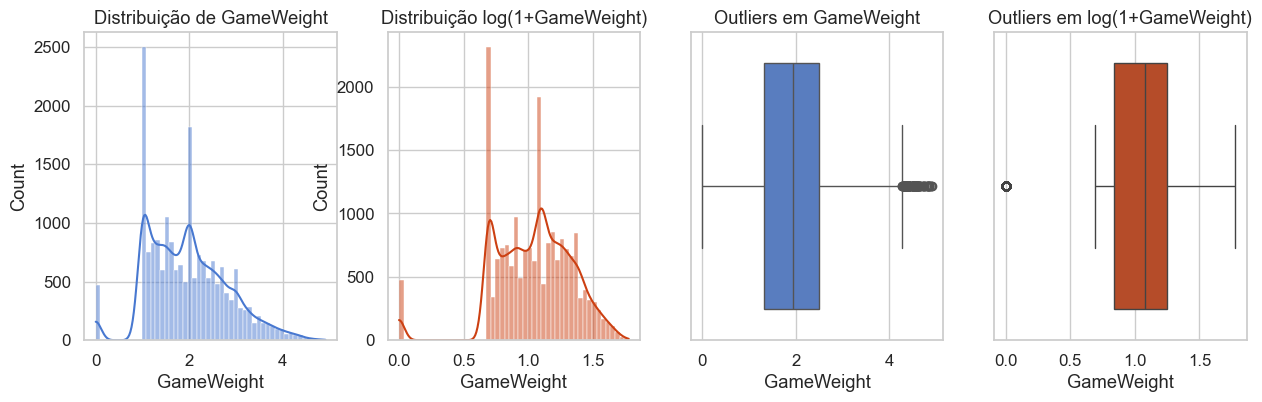

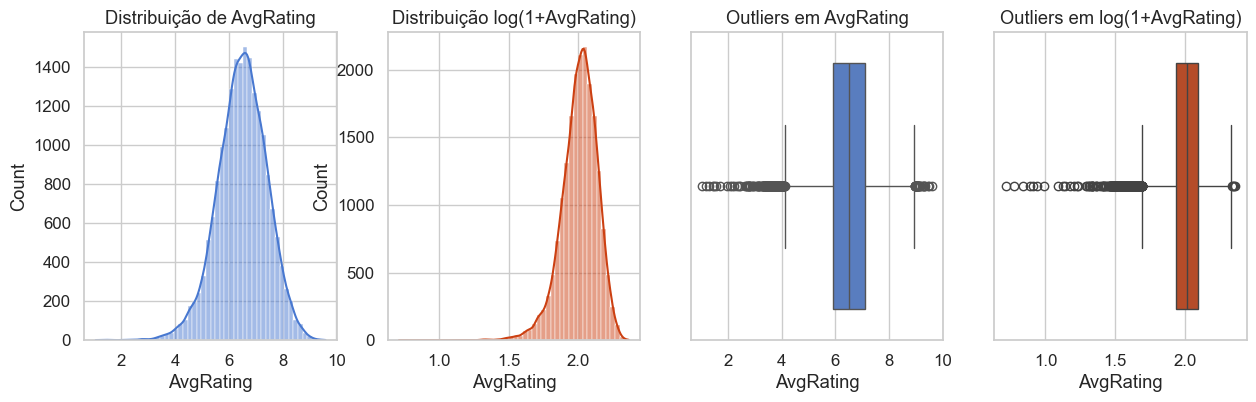

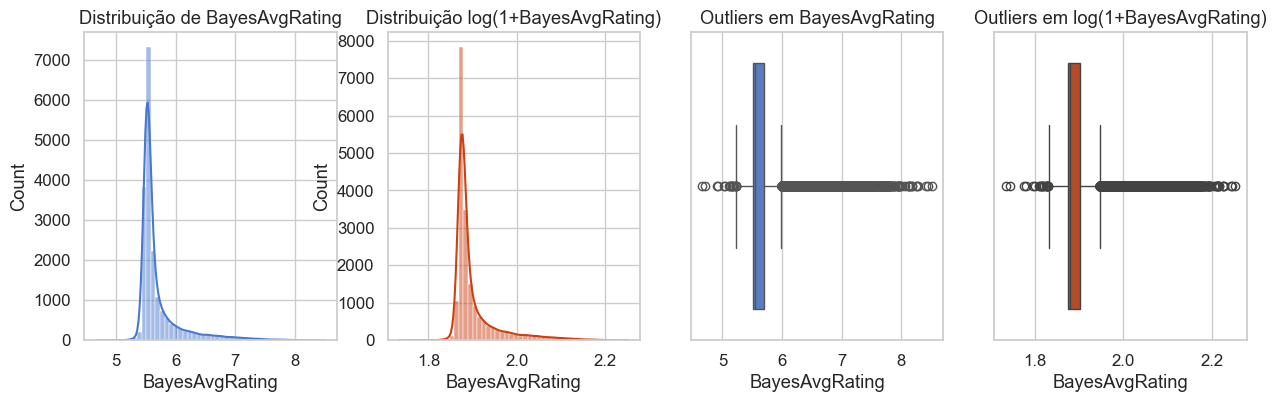

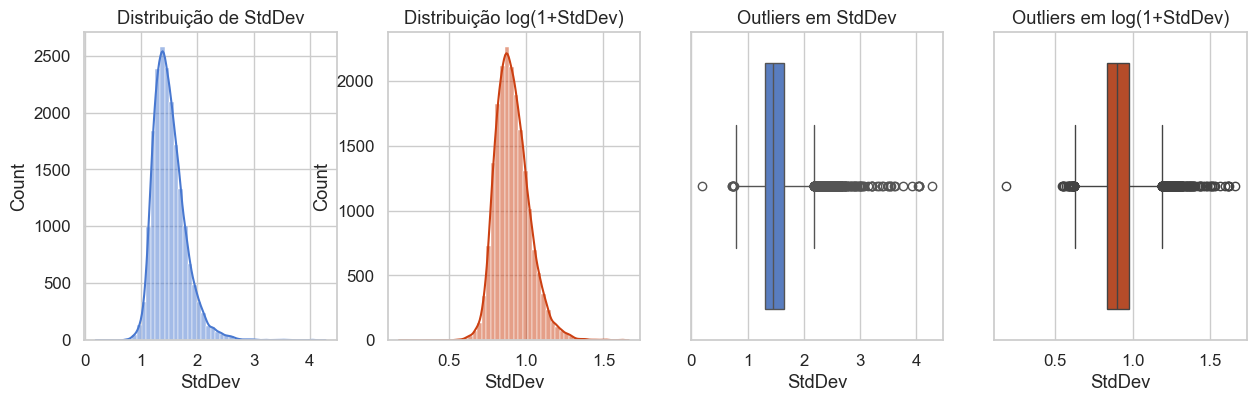

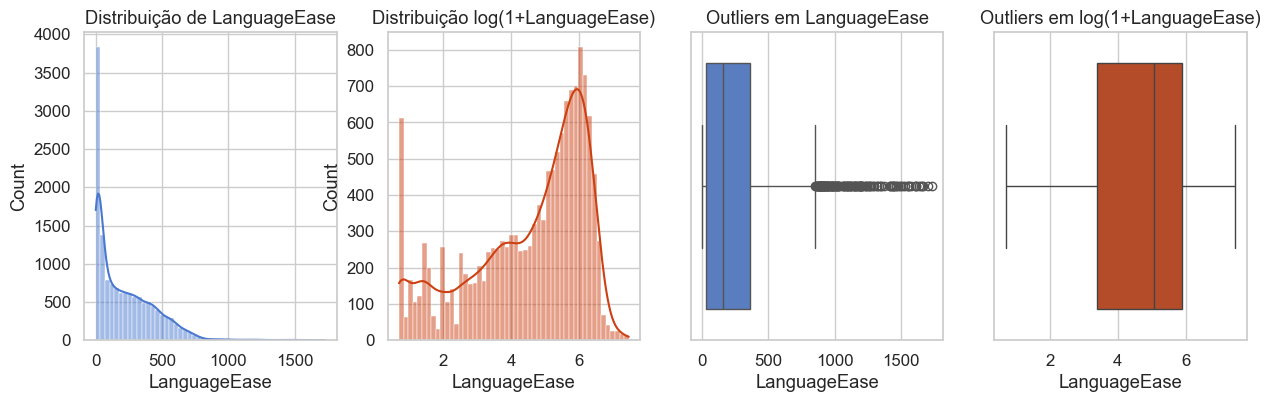

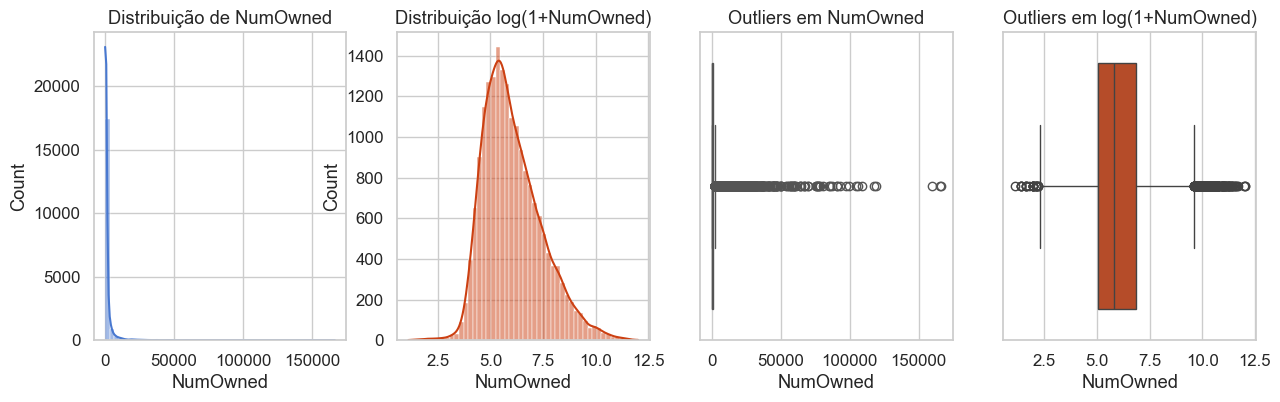

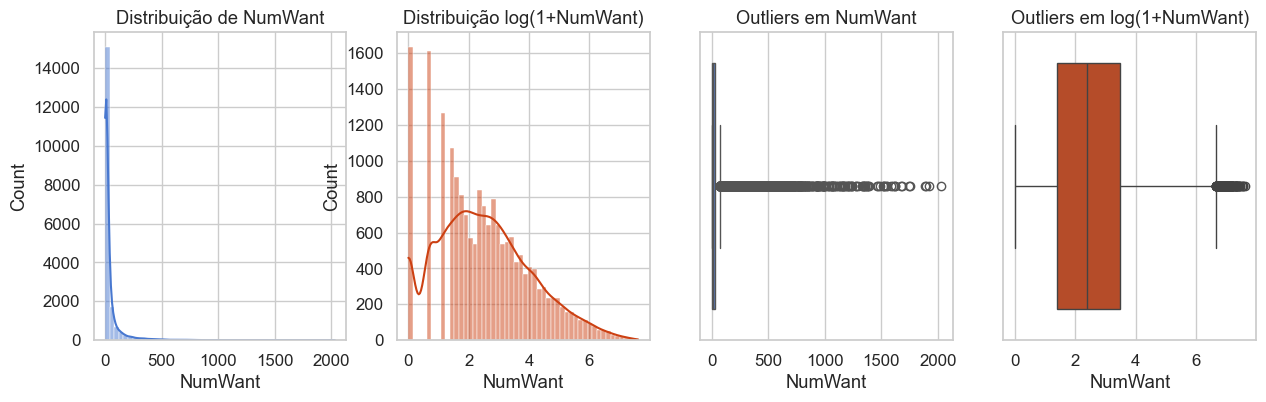

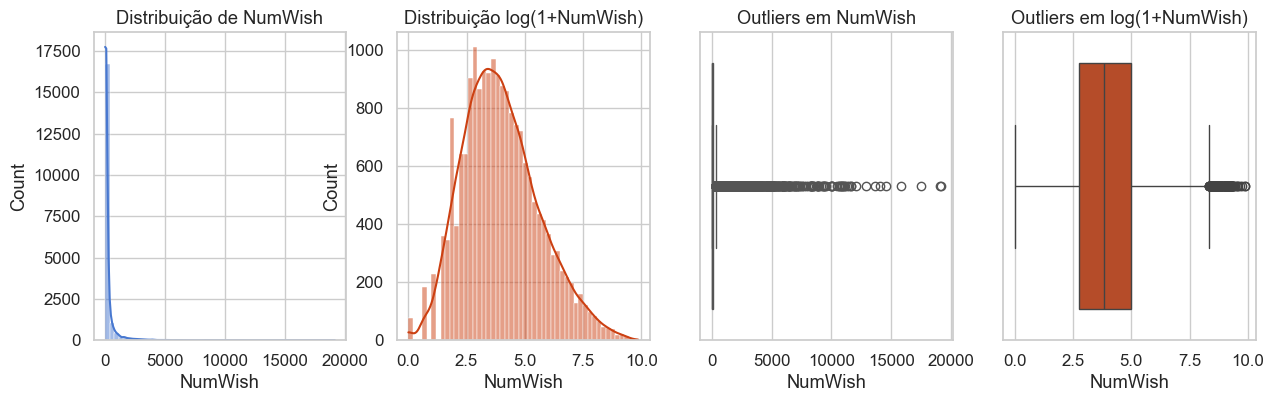

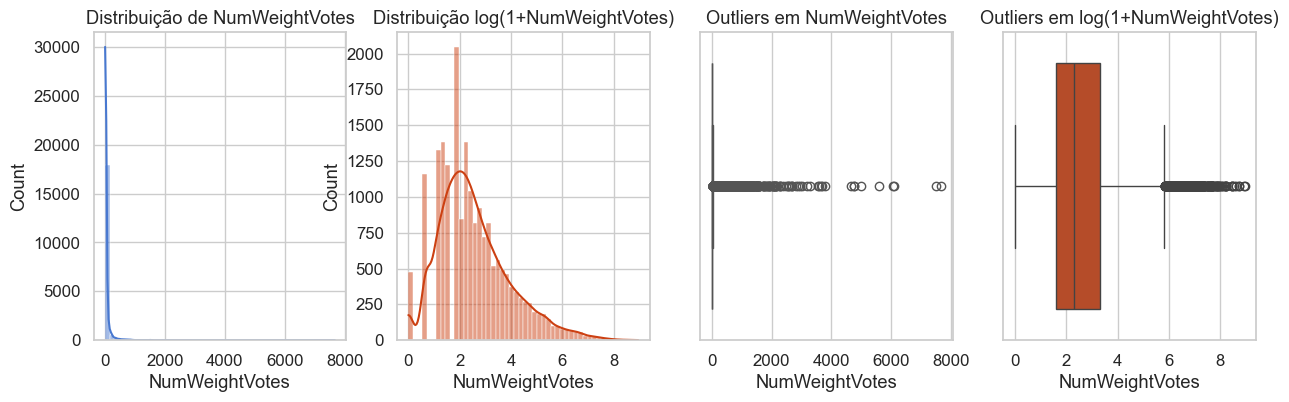

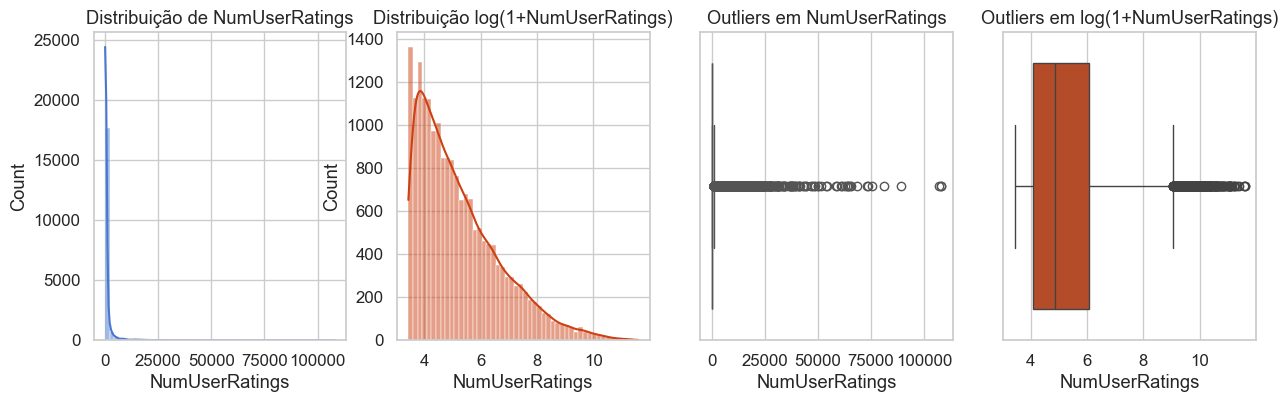

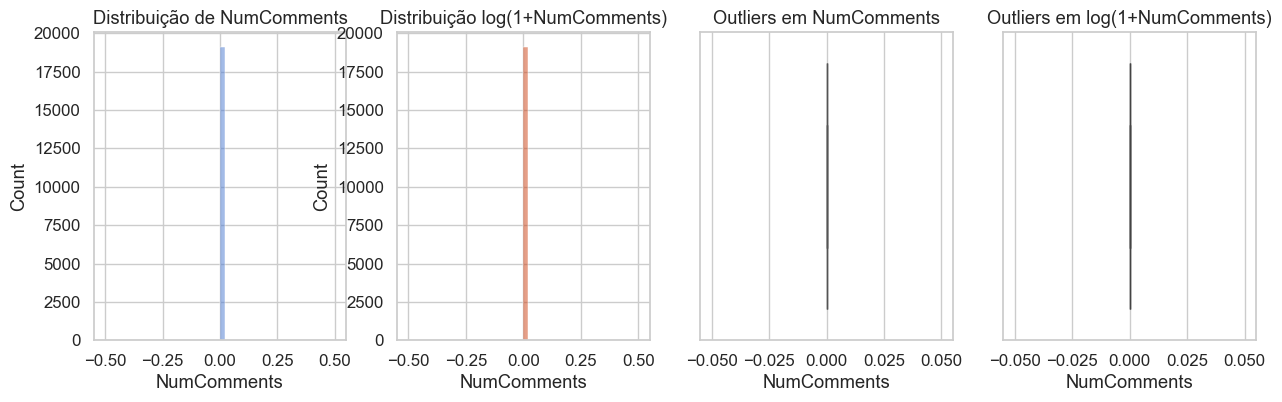

In [214]:
num_cols = metric_complex + pop_engaj

for col in num_cols:
    fig, axes = plt.subplots(1, 4, figsize=(15,4))  # 1 linha, 2 colunas

    # Histograma original
    sns.histplot(df[col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Distribuição de {col}")

    # Boxplot da distribuição original
    sns.boxplot(x=df[col], ax=axes[2])
    axes[2].set_title(f"Outliers em {col}")

    # Histograma log(1+x)
    sns.histplot(np.log1p(df[col]), bins=50, kde=True, ax=axes[1], color='#cc4012')
    axes[1].set_title(f"Distribuição log(1+{col})")

    # Boxplot da distribuição log(1+x)
    sns.boxplot(x=np.log1p(df[col]), ax=axes[3], color='#cc4012')
    axes[3].set_title(f"Outliers em log(1+{col})")    

    #plt.tight_layout()
    plt.show()


### Analise de correlação

Pares com correlação acima de 85%:

       Variável 1      Variável 2  Correlação
0        NumOwned  NumWeightVotes    0.872141
1        NumOwned  NumUserRatings    0.985809
2         NumWant         NumWish    0.940025
3  NumWeightVotes  NumUserRatings    0.916105


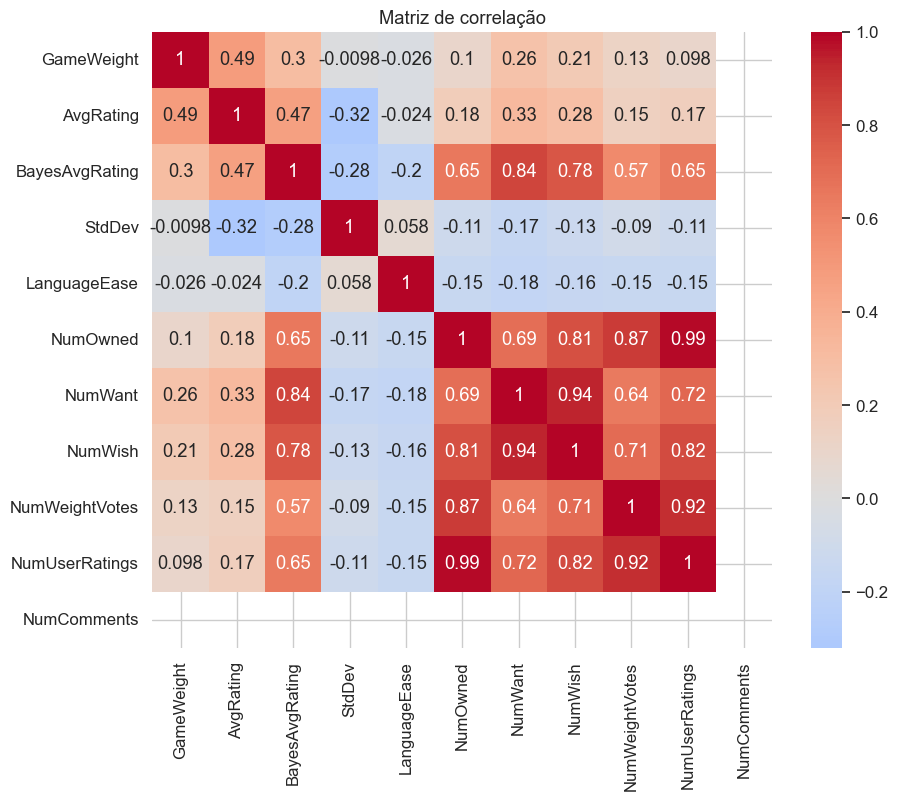

In [216]:
# 3. Correlação entre as variáveis numéricas

ficam = ['GameWeight', #peso do jogo aplicar one-hot enconding
        #'AvgRating',
        'BayesAvgRating', #nota ponderada
        'StdDev', #polaridade das notas
        #'LanguageEase',
        #'NumOwned',
        'NumWant', #número de usuários que querem o jogo
        #'NumWish',
        #'NumWeightVotes',
        'NumUserRatings' #número de avaliações - popularidade
        #'NumComments'
        ]

# remover = [var for var in num_cols if var not in ficam]
remover = ['']

corr_cols = [c for c in num_cols if c not in remover] 

# Matriz de correlação
corr_matrix = df[corr_cols].corr()

# Encontrar pares com correlação > 0.9 (ou < -0.9)
threshold = 0.85
high_corr = []

# Percorrer a matriz (somente a parte superior, sem repetir pares)
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i,j]
        if abs(corr_value) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value))

# Mostrar os pares
high_corr_df = pd.DataFrame(high_corr, columns=['Variável 1', 'Variável 2', 'Correlação'])
print("Pares com correlação acima de 85%:\n")
print(high_corr_df)

# Plot da heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlação")
plt.show()


### Analise da distribuição dos dados


#### Pré-processamento da variável ``GameWeigth`` 



* **Distribuição de GameWeight:** O histograma original mostra uma distribuição com múltiplos picos (multimodal), não uma distribuição normal. Isso sugere que os jogos se agrupam em diferentes faixas de complexidade, como "leves", "médios" e "pesados". A distribuição também é assimétrica, com uma cauda longa para a direita, indicando a existência de jogos muito complexos.

* **Transformação Logarítmica:** A transformação log(1+x) conseguiu reduzir a assimetria e compactar os valores. No entanto, a distribuição ainda mantém os múltiplos picos.

* **Outliers:** O boxplot do GameWeight original confirma que há vários outliers, que são os jogos com uma complexidade muito alta. A transformação logarítmica conseguiu aproximar a maioria desses outliers da distribuição principal, embora alguns ainda permaneçam.


Uma saída para os "problemas" dessa variável seria transforma-la em um variável categórica e depois aplicar o *one-hot encoding*

In [ ]:
# Defina os limites (bins) e os nomes das categorias (labels)
bins = [0, 2, 3, 4, 5]
labels = ['Leve', 'Médio', 'Pesado', 'Muito Pesado']

# Crie a nova coluna 'WeightCategory'
df['WeightCategory'] = pd.cut(df['GameWeight'], bins=bins, labels=labels, right=False)

# Aplique o one-hot encoding para converter a categoria em colunas binárias
# O parâmetro 'drop_first=True' evita multicolinearidade, mas é opcional.
df_encoded = pd.get_dummies(df, columns=['WeightCategory'], prefix='Weight', dtype=int)

# Opcional: Remova a coluna 'GameWeight' original se não for mais necessária
# df_encoded = df_encoded.drop(columns=['GameWeight'])

# Exiba o resultado para ver como as novas colunas ficaram
print("DataFrame com One-Hot Encoding:")
print(df_encoded[['Name', 'GameWeight', 'WeightCategory_Leve', 'WeightCategory_Médio', 'WeightCategory_Pesado', 'WeightCategory_Muito Pesado']].head())


#### Pré-processamento da variável ``BayesAvgRating`` 



Para a análise de dados e a seleção de variáveis para um sistema de recomendação híbrido, a distinção entre AvgRating e BayesAvgRating é crucial, especialmente se você considera incluí-las na parte de filtragem colaborativa.

AvgRating é uma média simples e direta, calculada a partir de todas as avaliações de um jogo. O problema é que um jogo com apenas duas avaliações, ambas com nota 10, teria uma nota 10, o que pode não ser uma representação precisa da sua qualidade real.

BayesAvgRating tenta corrigir esse problema. Ela utiliza um método de ponderação que inclui o número de avaliações. Basicamente, ela assume um "número de avaliações padrão" com uma nota média padrão. À medida que um jogo recebe mais avaliações, o seu BayesAvgRating se aproxima mais do seu AvgRating, mas no início, ele é "puxado" em direção a essa média padrão, o que o torna uma medida mais justa e confiável, especialmente para jogos com poucas avaliações.

Em um sistema de recomendação, o BayesAvgRating tende a ser uma variável mais robusta, pois evita que jogos com poucas avaliações e notas extremas tenham um peso indevido.

Variabilidade: A baixa variabilidade em BayesAvgRating, onde a maioria dos valores se concentra em torno da média, é uma característica positiva para um sistema de recomendação. Isso sugere que a variável é um sinal estável e confiável da qualidade percebida dos jogos, evitando ruídos de notas extremas que poderiam ocorrer com AvgRating. Um modelo pode usar essa variável para identificar de forma consistente jogos de alta e baixa qualidade, o que pode ser muito útil.

Outliers: Você está certo, não é ideal perder informações descartando as observações. Uma ótima alternativa é a limitação de valores extremos (ou capping). Essa técnica substitui os valores fora de um determinado limite (por exemplo, os 5% mais altos e mais baixos) por um valor de corte (o valor do percentil, por exemplo). Isso "ajusta" os outliers para um valor mais razoável sem remover a observação, preservando o restante da informação.

Claro, o capping (ou limitação de valores) é uma técnica de pré-processamento de dados usada para tratar outliers sem precisar remover as observações da sua base de dados.

A ideia é bem simples: em vez de excluir os dados extremos, você os "ajusta". Funciona assim:

Você define um limite superior (por exemplo, o percentil de 99% da sua variável).

Todos os valores acima desse limite são substituídos por esse próprio limite.

Você faz o mesmo para um limite inferior (por exemplo, o percentil de 1%), substituindo todos os valores abaixo dele.

Na prática, é como colocar um "teto" e um "piso" nos seus dados. Isso garante que a sua variável não tenha valores extremos que possam distorcer a análise ou prejudicar o desempenho do modelo, mas sem perder a informação de que esses jogos existem.

1º percentil (piso): 5.2273925
99º percentil (teto): 5.9905325

Número de observações abaixo do 1º percentil: 18
Número de observações acima do 99º percentil: 2528


C:\Users\isabelly.almeida\AppData\Local\Temp\ipykernel_18532\3206323807.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BayesAvgRating_unilateral_capped'] = np.clip(df['BayesAvgRating'], a_min=lim_min, a_max=np.inf)


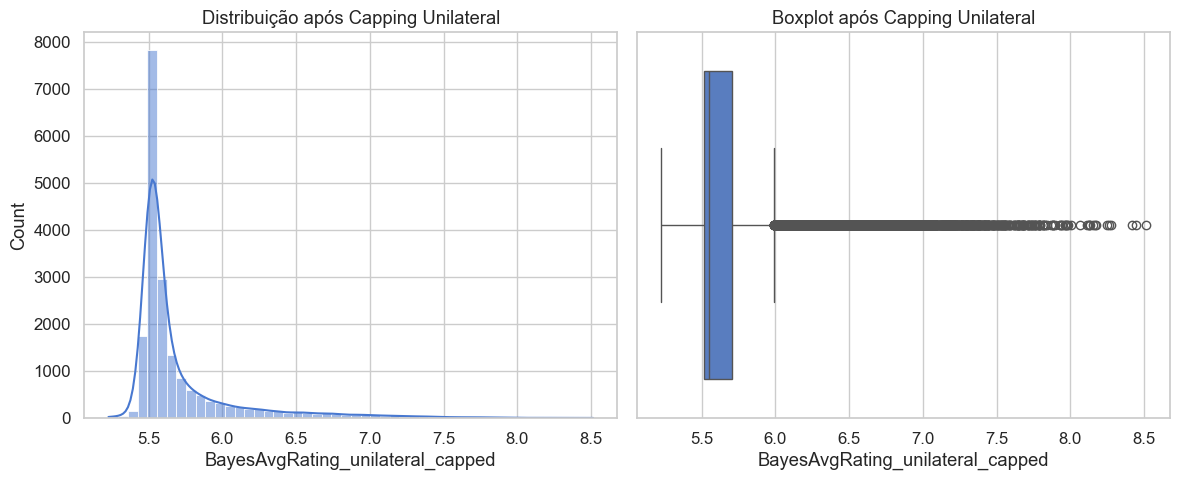

In [156]:
# Correção dos outliers da variável BayesAvgRating usando capping

IQR = df["BayesAvgRating"].quantile(0.75) - df["BayesAvgRating"].quantile(0.25)

lim_min = df["BayesAvgRating"].quantile(0.25) - 1.5 * IQR
lim_max = df["BayesAvgRating"].quantile(0.75) + 1.5 * IQR

print(f"1º percentil (piso): {lim_min}")
print(f"99º percentil (teto): {lim_max}")

outlier_down = df[df['BayesAvgRating'] < lim_min].shape[0]
outlier_up = df[df['BayesAvgRating'] > lim_max].shape[0]

print(f"\nNúmero de observações abaixo do 1º percentil: {outlier_down}")
print(f"Número de observações acima do 99º percentil: {outlier_up}")


# Aplique o capping unilateral.
df['BayesAvgRating_unilateral_capped'] = np.clip(df['BayesAvgRating'], a_min=lim_min, a_max=np.inf)

# Visualize a nova distribuição com um histograma e um boxplot.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograma da distribuição após capping.
sns.histplot(df['BayesAvgRating_unilateral_capped'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribuição após Capping Unilateral")

# Boxplot da distribuição após capping.
sns.boxplot(x=df['BayesAvgRating_unilateral_capped'], ax=axes[1])
axes[1].set_title("Boxplot após Capping Unilateral")

plt.tight_layout()
plt.show()

#### Análise da Variável ``StdDev``



A variável StdDev pode parecer, à primeira vista, apenas um detalhe estatístico, mas ela é, na verdade, uma medida de polaridade que pode ser extremamente valiosa para um sistema de recomendação.

Aqui está o porquê ela pode ser importante:

Um jogo com um alto StdDev é um jogo "ame ou odeie". A nota média pode até ser mediana, mas a dispersão alta indica que ele tem um público que o ama (notas altas) e outro que o odeia (notas baixas). Para um sistema de recomendação, essa informação é ouro. Se um usuário já avaliou positivamente um jogo divisivo, ele provavelmente gostaria de outros jogos "polêmicos" do mesmo tipo.

Por outro lado, um jogo com baixo StdDev tem um consenso de que é "bom" ou "ruim". A maioria das pessoas concorda com a nota média. Se o seu objetivo é recomendar jogos seguros, que agradam a um público mais amplo, um baixo StdDev pode ser um sinal útil.

A inclusão dessa variável no seu modelo de filtragem colaborativa permitiria que o sistema não apenas sugerisse jogos com base em sua similaridade de mecânica (cosine_similarity) e nota média (BayesAvgRating), mas também com base em sua similaridade de "polaridade" (StdDev).

A análise da variável **`StdDev`** nos dá as seguintes informações.

* O **histograma original** mostra uma distribuição fortemente assimétrica (com cauda à direita). Isso significa que, na grande maioria dos jogos, as avaliações dos usuários são muito consistentes (baixo desvio padrão), mas há alguns jogos que são extremamente divisivos, com uma grande variação nas notas.
* A **transformação log(1+StdDev)** foi extremamente eficaz. O histograma transformado é muito mais simétrico e se aproxima de uma distribuição normal. Isso remove a assimetria e compacta os outliers, tornando a variável muito mais adequada para a maioria dos modelos de machine learning.
* Os **boxplots** confirmam que a transformação logarítmica conseguiu trazer a grande maioria dos outliers de volta para perto da distribuição principal, eliminando os valores extremos que poderiam prejudicar o seu modelo.

Limite mínimo do boxplot (piso): 0.7816375000000001
Limite máximo do boxplot (teto): 2.1807374999999998

Número de observações abaixo do 1º percentil: 7
Número de observações acima do 99º percentil: 476


C:\Users\isabelly.almeida\AppData\Local\Temp\ipykernel_18532\58143816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev_capped'] = np.clip(df['StdDev'], a_min=lim_min, a_max=lim_max)
C:\Users\isabelly.almeida\AppData\Local\Temp\ipykernel_18532\58143816.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log1p_StdDev'] = np.log1p(df['StdDev'])


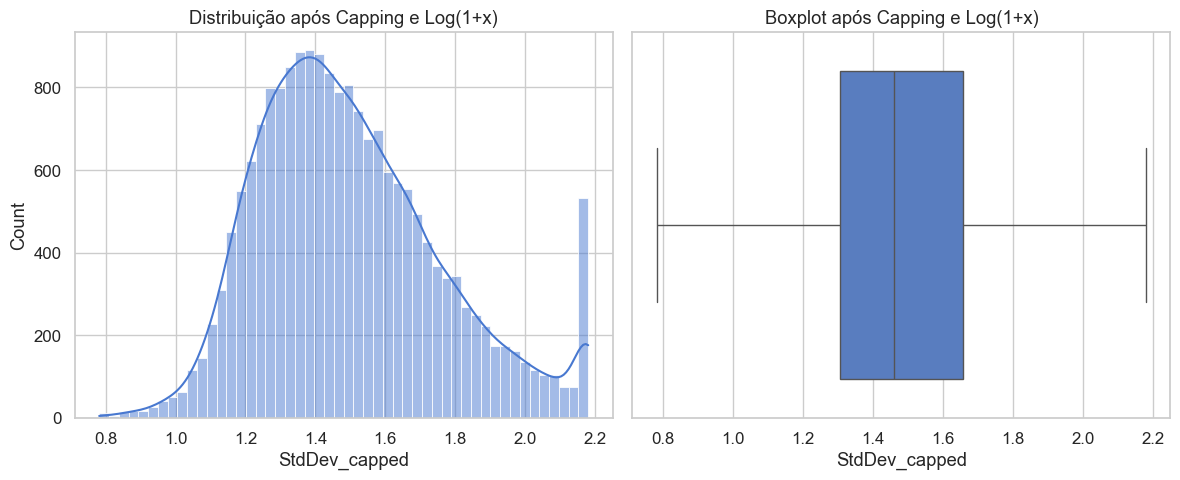

In [187]:
# Tratamento de outliers com capping 
IQR = df["StdDev"].quantile(0.75) - df["StdDev"].quantile(0.25)

lim_min = df["StdDev"].quantile(0.25) - 1.5 * IQR
lim_max = df["StdDev"].quantile(0.75) + 1.5 * IQR

print(f"Limite mínimo do boxplot (piso): {lim_min}")
print(f"Limite máximo do boxplot (teto): {lim_max}")

outlier_down = df[df['StdDev'] < lim_min].shape[0]
outlier_up = df[df['StdDev'] > lim_max].shape[0]

print(f"\nNúmero de observações abaixo do 1º percentil: {outlier_down}")
print(f"Número de observações acima do 99º percentil: {outlier_up}")


# Aplique o capping unilateral.
df['StdDev_capped'] = np.clip(df['StdDev'], a_min=lim_min, a_max=lim_max)

# Log(1+x) na variável StdDev
df['log1p_StdDev'] = np.log1p(df['StdDev'])

# Visualize a nova distribuição com um histograma e um boxplot.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograma da distribuição após capping.
sns.histplot(df['StdDev_capped'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribuição após Capping e Log(1+x)")

# Boxplot da distribuição após capping.
sns.boxplot(x=df['StdDev_capped'], ax=axes[1])
axes[1].set_title("Boxplot após Capping e Log(1+x)")

plt.tight_layout()
plt.show()

#### Analises da variável descartadas



- ``LanguageEase``: Será ignorada da analise, uma vez que muitos jogos são traduzidos para idioma local e perdem a necessidade de conhecimento da linguagem original de publicação ou com o inglês.

- ``NumOwned``, ``NumWeightVotes`` e ``NumUserRatings``:  
    - NumUserRatings parece ser a melhor opção, pois é a mais altamente correlacionada com as outras duas (0.985 com NumOwned e 0.917 com NumWeightVotes). Isso significa que ela captura o sinal de popularidade e engajamento das outras duas variáveis de forma muito eficiente, sendo uma excelente representante para o grupo.

    - NumOwned é uma medida de popularidade mais geral (posse). Se o objetivo é recomendar jogos que são "mainstream" ou um sucesso de vendas, essa seria a melhor escolha.

    - NumWeightVotes é um indicador de engajamento em um nicho específico da comunidade (análise de complexidade). Se o seu modelo foca em jogos para entusiastas, essa variável pode ser um bom diferencial.

- ``NumComments``: Coluna cheia de zeros. 

Ao analisar a matriz de correlação, foram identificados pares de variáveis altamente correlacionadas (acima de 0,85), o que indica forte redundância de informação entre elas. Para reduzir multicolinearidade e simplificar o modelo, foi necessário escolher apenas uma variável representativa em cada grupo de correlação.

No caso do grupo formado por NumUserRatings, NumOwned e NumWeightVotes, a variável escolhida para ser mantida foi NumUserRatings, por ser a mais diretamente relacionada à quantidade de avaliações recebidas, representando de forma clara a popularidade e o engajamento real dos jogadores. As variáveis NumOwned e NumWeightVotes foram descartadas por apresentarem correlação extremamente alta com NumUserRatings (0,98 e 0,91, respectivamente), tornando-as redundantes.

De forma análoga, no grupo formado por NumWant e NumWish, optou-se por manter NumWant, uma vez que expressa de forma mais objetiva o interesse ativo dos usuários em adquirir o jogo. A variável NumWish, com correlação de 0,93 com NumWant, foi descartada para evitar redundância.

Assim, permanecem no modelo as variáveis NumUserRatings e NumWant, representando, de maneira não redundante, duas dimensões importantes do engajamento: a quantidade de avaliações e o interesse futuro em possuir o jogo.

### Justificativa para manter a variável NumWant



Embora exista uma correlação relativamente alta entre BayesAvgRating e NumWant (0,83), as duas variáveis capturam dimensões distintas do comportamento dos jogadores.

BayesAvgRating reflete a qualidade consolidada de um jogo, baseada em avaliações ajustadas estatisticamente para reduzir vieses de amostras pequenas.

NumWant, por outro lado, mede o desejo da comunidade em possuir determinado título, funcionando como um indicador de popularidade futura ou hype.

A correlação elevada entre elas é intuitiva: jogos bem avaliados tendem a gerar mais interesse. Contudo, isso não significa que ambas variáveis sejam totalmente redundantes. O desejo de adquirir um jogo pode ser influenciado também por fatores externos ao score de qualidade — como campanhas de marketing, prêmios recebidos, novidades do autor/editora ou tendência de mercado.

Portanto, a inclusão de NumWant no modelo é justificada, pois:

Captura hype/popularidade que não é explicado apenas pela avaliação de qualidade.

Complementa o BayesAvgRating, permitindo que o sistema recomende não apenas jogos consagrados, mas também títulos em ascensão, aumentando a atratividade para o usuário.

Garante que o modelo não fique enviesado somente para jogos “clássicos” e já estabelecidos, mas consiga refletir o dinamismo do mercado de jogos modernos.

Assim, manter NumWant ao lado de BayesAvgRating agrega valor ao modelo ao equilibrar qualidade consolidada com tendências emergentes da comunidade.

#### Relações entre as variáveis escolhidas num primeiro momento

In [ ]:
# Variáveis escolhidas até o momento
df['BayesAvgRating_unilateral_capped']
df['log1p_NumWant'] = np.log1p(df['NumWant'])
df['log1p_NumUserRatings'] = np.log1p(df['NumUserRatings'])

C:\Users\isabelly.almeida\AppData\Local\Temp\ipykernel_18532\532230735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log1p_NumWant'] = np.log1p(df['NumWant'])
C:\Users\isabelly.almeida\AppData\Local\Temp\ipykernel_18532\532230735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log1p_NumUserRatings'] = np.log1p(df['NumUserRatings'])


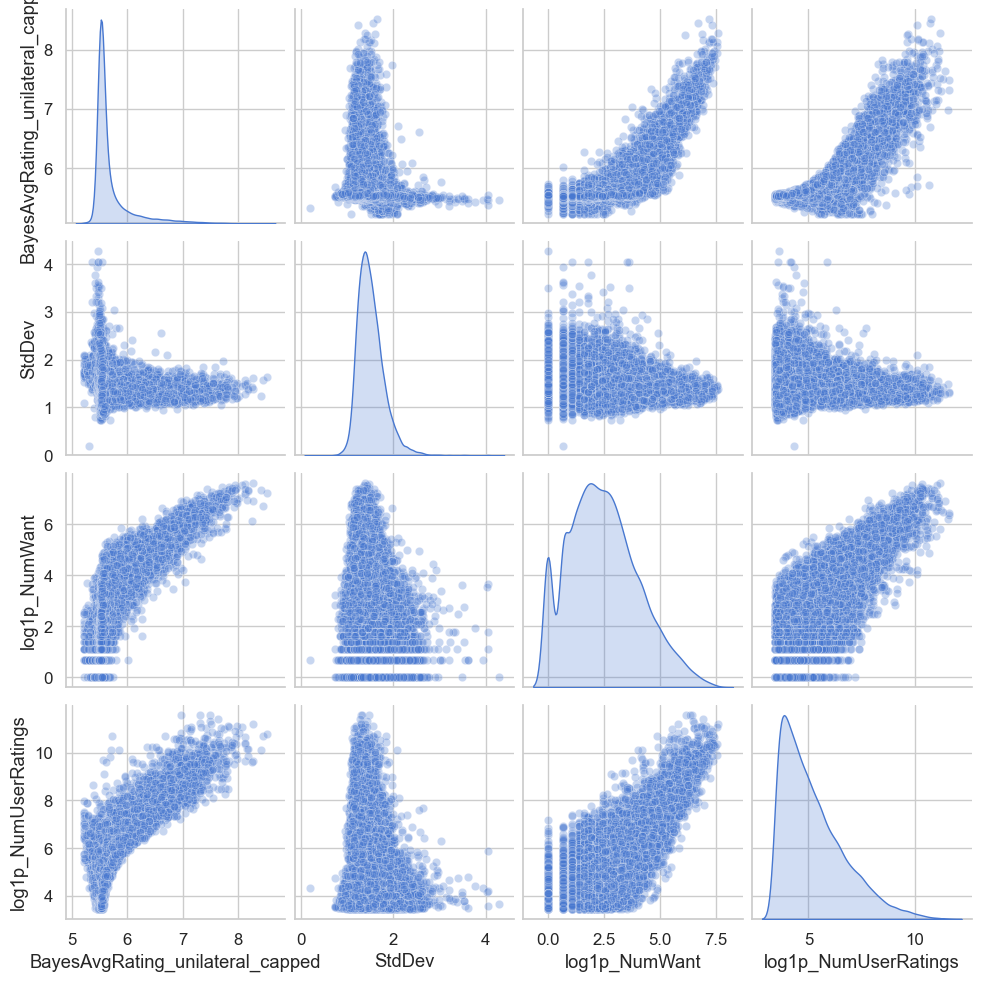

In [ ]:
# 4. Relações relevantes

# Criação do pair plot
sns.pairplot(df[['BayesAvgRating_unilateral_capped', 'StdDev', 'log1p_NumWant', 'log1p_NumUserRatings']], diag_kind="kde", plot_kws={"alpha":0.3})
plt.show()

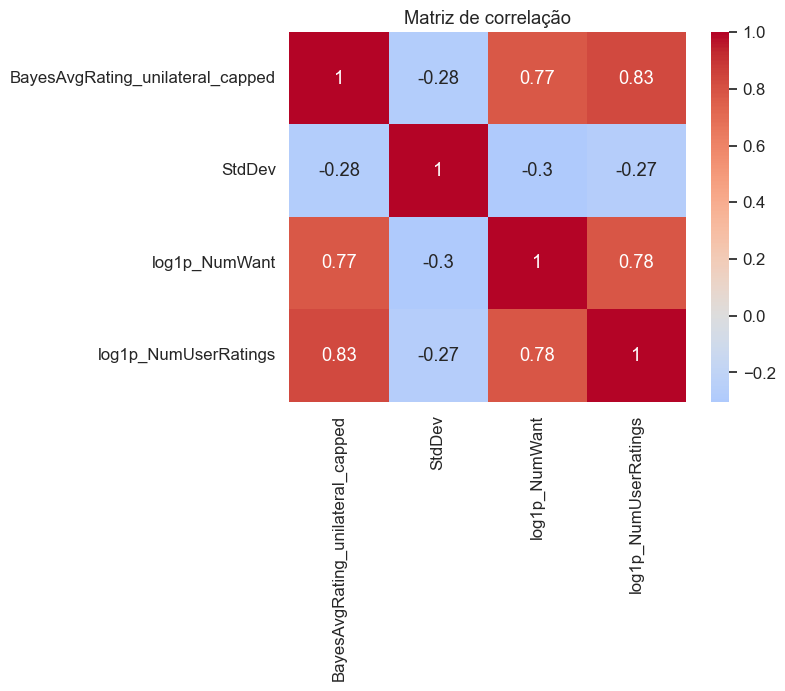

In [194]:
# Matriz de correlação
corr_matrix = df[['BayesAvgRating_unilateral_capped', 'StdDev', 'log1p_NumWant', 'log1p_NumUserRatings']].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlação")   
plt.show()